In [1]:
!pip install PyDrive
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install plotly-geo
!pip install fiona

     |████████████████████████████████| 890kB 2.8MB/s 
     |████████████████████████████████| 10.9MB 17.4MB/s 
     |████████████████████████████████| 14.7MB 47.5MB/s 
     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for pyshp: filename=pyshp-1.2.10-cp36-none-any.whl size=20467 sha256=6dcfa68052095ddb7ad629b89b34de47b5c005bc2f9be3ed7d47233823203765
  Stored in directory: /root/.cache/pip/wheels/ba/1a/67/6a12977f362c33a15edc753daf92c6f01879dbf4db76faf0dd
Successfully built pyshp
     |████████████████████████████████| 1.5MB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.0
    Uninstalling Shapely-1.7.0:
      Successfully uninstalled Shapely-1.7.0
     |████████████████████████████████| 23.7MB 1.3MB/s 


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Solution to how to share these with anybody viewing this notebook by wenkesj:
# https://stackoverflow.com/questions/48376580/google-colab-how-to-read-data-from-my-google-drive

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1x1ffPih_UoWxkJvh8W2WwCjy_8IEn_jg' in parents"}).GetList()
for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: metropolitan-areas.csv, id: 16Yjd3U75U9ADBJHqkQYxst3V3uE56Co3
downloading to /root/data/metropolitan-areas.csv
title: time_series_covid19_deaths_US.csv, id: 1lX_fRy7eM_daVJ152FOwPKe0BG6l1Tkx
downloading to /root/data/time_series_covid19_deaths_US.csv
title: time_series_covid19_confirmed_US.csv, id: 16gjsrMLMqkFTslXOrta1jWKTRwTEThuz
downloading to /root/data/time_series_covid19_confirmed_US.csv
title: 4.18states.csv, id: 1MXmli-tEVFiUkOA7-NboitSwkfMbtRFY
downloading to /root/data/4.18states.csv
title: README.md, id: 1UP0YHuINGGXSYfzvRnIIPytm-ZS6OVnL
downloading to /root/data/README.md
title: abridged_couties.csv, id: 1b2pyj_1yFSIA3nH32PVWgvrVKEx9IW02
downloading to /root/data/abridged_couties.csv


In [3]:
#Libraries used 
import pandas as pd
import datetime
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#graphing libraries:
from urllib.request import urlopen
import json
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import folium
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The following are all the datasets used:

In [4]:
states = pd.read_csv("/root/data/4.18states.csv")
states.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-04-18 22:32:47,32.3182,-86.9023,4712,153,NaN,4559.0,1.0,100.492717,42538.0,620.0,3.247029,84000001,USA,907.206961,13.157895
1,Alaska,US,2020-04-18 22:32:47,61.3707,-152.4044,314,9,147.0,305.0,2.0,52.530410,9655.0,39.0,2.866242,84000002,USA,1615.226458,12.420382
2,American Samoa,US,NaN,-14.2710,-170.1320,0,0,NaN,NaN,60.0,0.000000,3.0,NaN,NaN,16,ASM,5.391708,NaN
3,Arizona,US,2020-04-18 22:32:47,33.7298,-111.4312,4724,180,539.0,4544.0,4.0,64.901548,51045.0,566.0,3.810330,84000004,USA,701.291175,11.981372
4,Arkansas,US,2020-04-18 22:32:47,34.9697,-92.3731,1744,38,703.0,1706.0,5.0,67.361213,24141.0,291.0,2.178899,84000005,USA,932.435235,16.685780


In [5]:
time_series_covid19_confirmed_US = pd.read_csv("/root/data/time_series_covid19_confirmed_US.csv")
time_series_covid19_confirmed_US.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,5,12,14,15,27,29,32,37,45,51,55,56,58,69,77,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,5,5,5,14,21,23,31,39,51,64,79,100,127,174,239,286,316,316,452,475,513,573,620,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,6,6,7,17,17,17,19,22,23,30,30,30,30,37,40,42,43,43,45,45,50,51,51,51,51,51,51,51,53


In [6]:
time_series_covid19_deaths_US = pd.read_csv("/root/data/time_series_covid19_deaths_US.csv")
time_series_covid19_deaths_US.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,3,3,3,6,8,11,12,15,18,20,21,23,24,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,3


In [7]:
metropolitan_areas = pd.read_csv("/root/data/metropolitan-areas.csv")
metropolitan_areas

,CBSA Code,Metropolitan Division Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,Metropolitan Division Title,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,Central/Outlying County,countyFIPS
0,10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Brown County,South Dakota,46,13,Central,46013
1,10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Edmunds County,South Dakota,46,45,Outlying,46045
2,10140,NaN,NaN,"Aberdeen, WA",Micropolitan Statistical Area,NaN,NaN,Grays Harbor County,Washington,53,27,Central,53027
3,10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Callahan County,Texas,48,59,Outlying,48059
4,10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Jones County,Texas,48,253,Outlying,48253
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911,49700,NaN,472.0,"Yuba City, CA",Metropolitan Statistical Area,NaN,"Sacramento-Roseville, CA",Sutter County,California,6,101,Central,6101
1912,49700,NaN,472.0,"Yuba City, CA",Metropolitan Statistical Area,NaN,"Sacramento-Roseville, CA",Yuba County,California,6,115,Central,6115
1913,49740,NaN,NaN,"Yuma, AZ",Metropolitan Statistical Area,NaN,NaN,Yuma County,Arizona,4,27,Central,4027
1914,49780,NaN,198.0,"Zanesville, OH",Micropolitan Statistical Area,NaN,"Columbus-Marion-Zanesville, OH",Muskingum County,Ohio,39,119,Central,39119


In [8]:
abridged_counties = pd.read_csv("/root/data/abridged_couties.csv")
abridged_counties.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944

#EDA

The following maps were created to observe the severity rate of the following states. 

The first step in EDA was just to begin looking at some graphs and seeing if there are some patterns that emerge. The next few graphs indicate the incident rate of every state to check for patterns of outbreak severity.

In [9]:
#tidy the data
US_deaths=time_series_covid19_deaths_US
US_deaths=states[states.Country_Region=='US']

US_confirmed=time_series_covid19_confirmed_US
US_confirmed=states[states.Country_Region=='US']
#group the states 
graph= US_confirmed.groupby(["Province_State"]).sum().reset_index()
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
#def choropleth(geo_data, data, columns, legend_name)
#Json retrieving map of states
m = folium.Map(location=[37, -102], zoom_start=5,max_zoom=4.5,min_zoom=3)   
folium.Choropleth(
      geo_data=state_geo,
      name='choropleth',
      data= graph,
      columns=['Province_State', 'Incident_Rate'],
      key_on='feature.properties.name',
      fill_color='Greens',
      fill_opacity=0.8,
      line_opacity=0.2,
      #bins=list(graph['Incident_Rate'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1])),
      legend_name='Incident Rate by State'
      ).add_to(m)

folium.LayerControl().add_to(m)

display(m)
          


The data seems very skewed as there are great outliers, for example, NY. To account for the outliers, for the following maps we took the log of growth rate and the death rate. As well as we compared the death to confirmed cases. The confirmed cases aren't as reliable as there are limited testing in all states. Morbidly, the death rates from the datasets are more reliable.

In [10]:
graph=US_deaths.copy()
graph['log_Incident_Rate']=US_deaths['Incident_Rate'].apply(lambda x: np.log(x)).replace([np.inf, -np.inf], 0)


#Json retrieving map of states
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=10)
   
folium.Choropleth(
      geo_data=state_geo,
      name='choropleth',
      data= graph,
      columns=['Province_State','log_Incident_Rate'],
      key_on='feature.properties.name',
      fill_color='Greens',
      fill_opacity=0.5,
      line_opacity=0.2,
      #bins=list(graph['Deaths'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1])),
      legend_name='Incident Rate '
      ).add_to(m)

folium.LayerControl().add_to(m)

m

In [11]:
graph= US_confirmed.groupby(["Province_State"]).sum().reset_index()
graph['log_Incident_Rate']=graph['Incident_Rate'].apply(lambda x: np.log(x)).replace([np.inf, -np.inf], 0)
#Json retrieving map of states
m = folium.Map(location=[37, -102], zoom_start=4,max_zoom=10)
   
folium.Choropleth(
      geo_data=state_geo,
      name='choropleth',
      data= graph,
      columns=['Province_State','log_Incident_Rate'],
      key_on='feature.properties.name',
      fill_color='Purples',
      fill_opacity=0.5,
      line_opacity=0.2,
      #bins=list(graph['log_Incident_Rate'].quantile([0, 0.25, 0.5, 0.75,0.95 ,1])),
      legend_name='Log Incident Rate USA'
      ).add_to(m)

folium.LayerControl().add_to(m)
display(m)

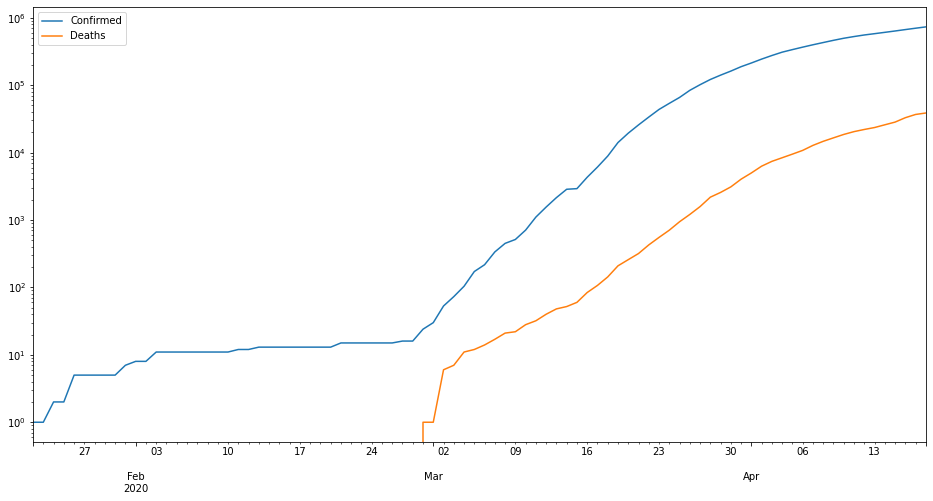

In [12]:
cum_confirmed = np.sum(time_series_covid19_confirmed_US)["1/22/20":]
cum_confirmed.index = pd.to_datetime(cum_confirmed.index)
cum_deaths = np.sum(time_series_covid19_deaths_US)["1/22/20":]
cum_deaths.index = pd.to_datetime(cum_confirmed.index)

fig, ax = plt.subplots(figsize = [16, 8])
cum_confirmed.plot(label = "Confirmed")
cum_deaths.plot(label = "Deaths")
plt.yscale("log")
plt.legend()

In [0]:
daily_new_confirmed = cum_confirmed.copy()
for i in np.arange(len(cum_confirmed)-1, 0, -1):
  daily_new_confirmed.iloc[i] = daily_new_confirmed.iloc[i] - daily_new_confirmed.iloc[i - 1]

In [14]:
daily_new_deaths = cum_deaths.copy()
for i in np.arange(len(daily_new_deaths)-1, 0, -1):
  daily_new_deaths.iloc[i] = daily_new_deaths.iloc[i] - daily_new_deaths.iloc[i - 1]
daily_new_deaths

2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
              ... 
2020-04-14    2303
2020-04-15    2494
2020-04-16    4591
2020-04-17    3857
2020-04-18    1891
Length: 88, dtype: object

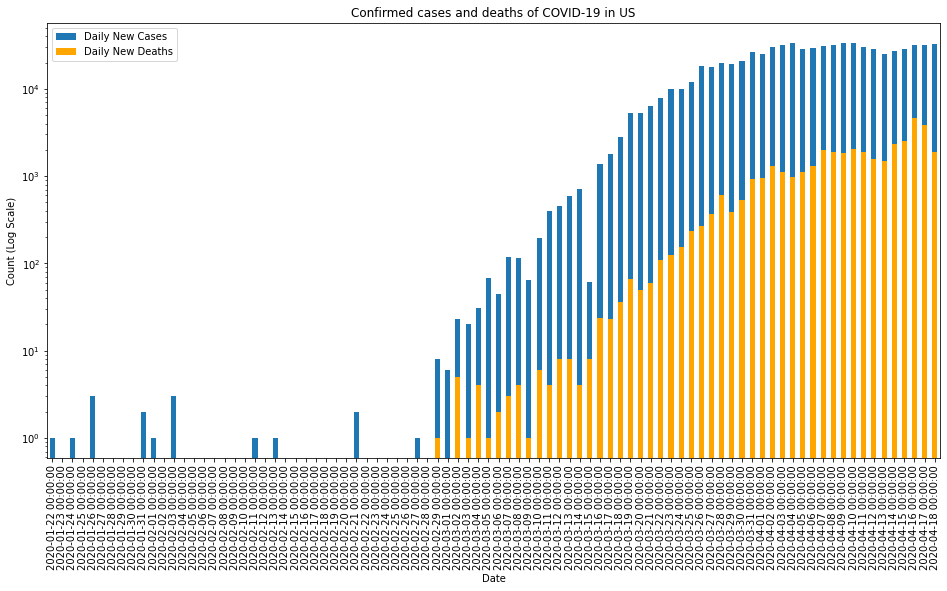

In [15]:
fig, ax = plt.subplots(figsize = [16, 8])
#cum_confirmed.plot(label = "Cummulative Confirmed")
#cum_deaths.plot(label = "Cummulative Deaths")
daily_new_confirmed.plot(kind = "bar", label = "Daily New Cases")
daily_new_deaths.plot(kind = "bar", color = "orange", label = "Daily New Deaths")
plt.yscale("log")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Count (Log Scale)")
#dates = cum_confirmed.index
plt.title("Confirmed cases and deaths of COVID-19 in US");

What we see here is some startling numbers for new infections, but it looks like the curve is flattening, right? Well, this is a logarithmic scale. While it's useful for understanding the rate of growth for an epidemic that grows exponentially, that slow curve is misleading. That just shows us that the exponential growth has slowed down.

Lets look at the same graph, but with a linear scale.

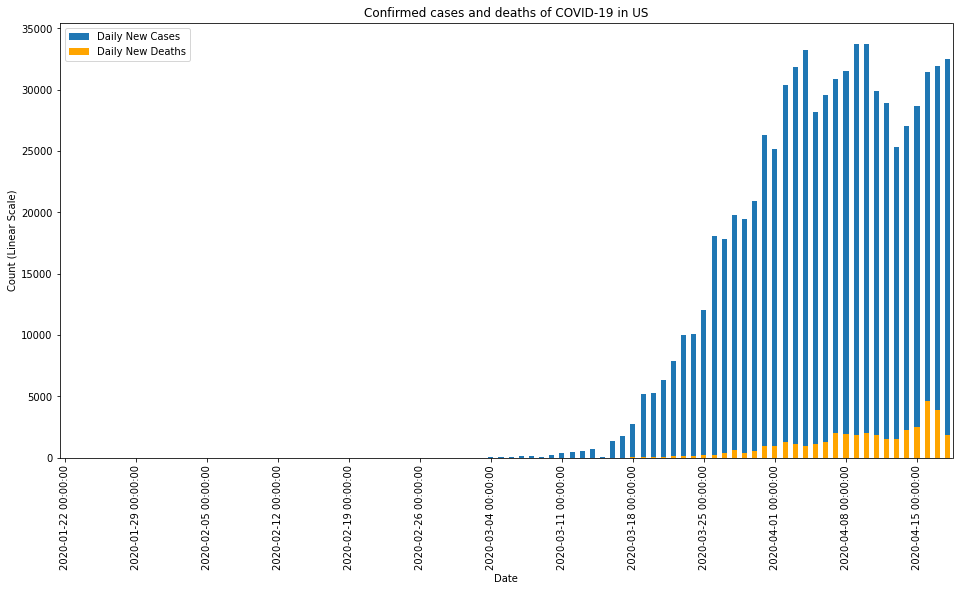

In [16]:
fig, ax = plt.subplots(figsize = [16, 8])
#cum_confirmed.plot(label = "Cummulative Confirmed")
#cum_deaths.plot(label = "Cummulative Deaths")
daily_new_confirmed.plot(kind = "bar", label = "Daily New Cases")
daily_new_deaths.plot(kind = "bar", color = "orange", label = "Daily New Deaths")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Count (Linear Scale)")
dates = cum_confirmed.index
plt.xticks(np.arange(0, len(dates), 7), dates[np.arange(0, len(dates), 7)])
plt.title("Confirmed cases and deaths of COVID-19 in US");

Now the scale of this epidemic is much clearer, but to understand if we are flattening the curve, we really want to look at the curve of the people that are currently sick. Unfortunately, it seems the dataset does not include that information. When looking at the source, we can see that there is a column for recovered, however the US does not seem to report those numbers.

We will take the WHO report that suggests that the recovery time is between 2 to 6 weeks to estimate active cases. I will arbitrarily estimate that the cases from the past 3 weeks are still active. This is a bit of a pessimistic guess, but in cases of pandemics I would say acting on pessimism is better than optimism. Note that the length for mild cases is 2 weeks, while the length for serious cases is 4-6 weeks. This is not an accurate measure, but just an attempt to estimate.

In [0]:
estimated_duration = 21

active = cum_confirmed.copy()
for i in np.arange(len(active)):
  active[i] = np.sum(daily_new_confirmed[i - estimated_duration:i+1])

removed = cum_confirmed.copy()
for i in np.arange(len(removed)):
  removed[i] = np.sum(daily_new_confirmed[:max(0,i - estimated_duration)])

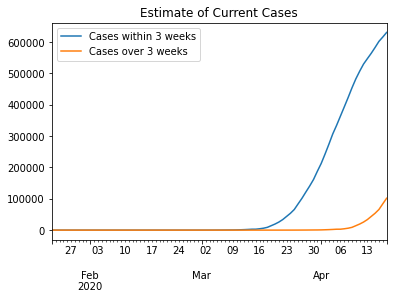

In [18]:
active.plot(label = "Cases within 3 weeks")
removed.plot(label = "Cases over 3 weeks")
plt.title("Estimate of Current Cases")
plt.legend();

This is a *very* rough estimation and largely relies on when tests are confirmed. It presumes an average duration of 21 days as well as accurate testing, which has been a problem worldwide (though especially in the United States). We can see the curve is slightly bending back down, but the number of active cases is still rising.
There is another way of estimating active cases using the deaths and a three week lag as expressed [here](https://www.medrxiv.org/content/10.1101/2020.03.17.20037697v2.full.pdf+html).

I am using a fatality rate of 3.4% as [estimated by the CDC](https://www.cdc.gov/mmwr/volumes/69/wr/mm6912e2.htm).

Additionally, I will be using methods to smooth out the curve especially as early numbers would be susceptible to chance when it comes to the date of death.

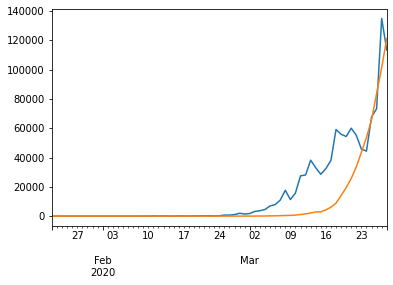

In [19]:
active_via_death = daily_new_deaths.copy().iloc[0:len(daily_new_deaths) - 21]
CDR = 0.034
for i in np.arange(len(active_via_death)):
  active_via_death.iloc[i] = daily_new_deaths.iloc[i + 20]/CDR

active_via_death.plot()
active.iloc[:len(cum_confirmed) - 21].plot(label = "Cases within 3 weeks")
#plt.pyplot.yscale("log")

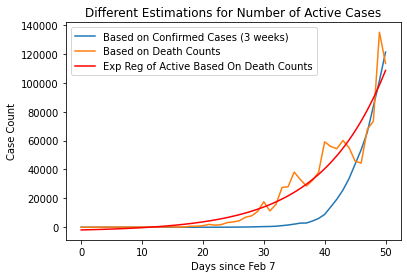

In [20]:
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b
expt, expcov = curve_fit(exponential, np.arange(len(active_via_death[16:])), active_via_death[16:].values, p0=[1, 1e-6, 1])
x_plot=np.linspace(0,len(active_via_death)-17,100)
plt.plot(np.arange(0, len(active_via_death)-16),active.iloc[16:len(cum_confirmed) - 21].values, label = "Based on Confirmed Cases (3 weeks)")
plt.plot(np.arange(0, len(active_via_death)-16), active_via_death[16:].values, label = "Based on Death Counts")
plt.plot(x_plot, exponential(x_plot, *expt), 'r-', label = "Exp Reg of Active Based On Death Counts")
plt.legend()
plt.xlabel("Days since Feb 7")
plt.ylabel("Case Count")
plt.title("Different Estimations for Number of Active Cases");
#print(expt)

We can actually use this to see which death rates seem reasonable. While these are all rough estimations as the true values of cases is impossible to know, wildly diverging estimations would be an indicator of one of the models or assumptions being model is incorrect. Lets take, for example, a death rate of 7% as suggested by some institutions.

In [0]:
def predict_via_death(daily_deaths, cdr = 0.034):
  active_via_death = daily_deaths.copy().iloc[0:len(daily_deaths) - 21]
  for i in np.arange(len(active_via_death)):
    active_via_death.iloc[i] = daily_new_deaths.iloc[i + 20]/cdr
  return active_via_death  
  

In [0]:
def plot_active_estimations(confirmed_est, daily_deaths, cdr = 0.034):
  def exponential(x, a, k, b):
    return a*np.exp(x*k) + b
  active_via_death = predict_via_death(daily_deaths, cdr)
  trim = 0
  while active_via_death[0] == 0:
    active_via_death = active_via_death[1:]
    trim += 1
  expt, expcov = curve_fit(exponential, np.arange(len(active_via_death)), active_via_death.values, p0=[1, 1e-6, 1])
  #fig, ax = plt.subplot()
  x_plot=np.linspace(0,len(active_via_death)-1,100)
  plt.plot(np.arange(0, len(active_via_death)),active.iloc[trim:trim + len(active_via_death)].values, label = "Based on Confirmed Cases (3 weeks)")
  plt.plot(np.arange(0, len(active_via_death)), active_via_death.values, label = "Based on Death Counts")
  plt.plot(x_plot, exponential(x_plot, *expt), 'r-', label = "Exp Reg of Active Based On Death Counts")
  plt.legend()
  plt.xlabel("Days since Feb 7")
  plt.ylabel("Case Count")
  plt.title(f"Different Estimations for Number of Active Cases (CDR = {cdr})"); 

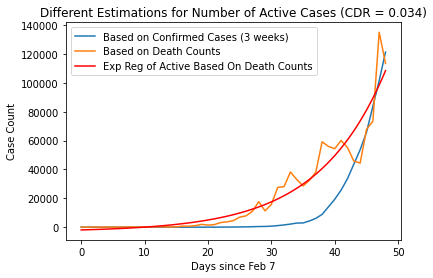

In [23]:
plot_active_estimations(active, daily_new_deaths, cdr = 0.034)

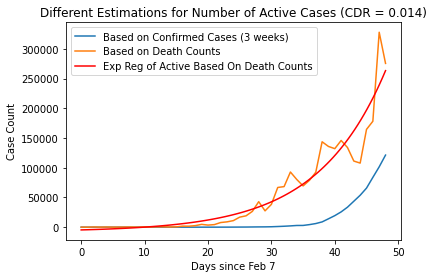

In [24]:
plot_active_estimations(active, daily_new_deaths, cdr = 0.014)

The accuracy of these models depend very much on proper data collection and knowledge of the virus, though the number of confirmed cases acts as a floor to the number of infections. It is widely assumed that this is a gross undercount of people that are affected largely due to failures in testing and asymptomatic people. Lets take a look at the regression lines based on various assumptions of death rate.

In [0]:
def death_pred_comparison(list_of_rates, daily_deaths):
  def exponential(x, a, k, b):
    return a*np.exp(x*k) + b
  active_via_death = predict_via_death(daily_deaths)
  trim = 0
  while active_via_death[0] == 0:
    active_via_death = active_via_death[1:]
    trim += 1
  for rate in list_of_rates:
    active_via_death = predict_via_death(daily_deaths, rate)
    active_via_death = active_via_death[trim:]
    expt, expcov = curve_fit(exponential, np.arange(len(active_via_death)), active_via_death.values, p0=[1, 1e-6, 1])
    x_plot=np.linspace(0,len(active_via_death)-1,100)
    plt.plot(x_plot, exponential(x_plot, *expt), label = str(np.round(rate * 100, 2)) + "%")
  plt.plot(np.arange(0, len(active_via_death)),active.iloc[trim:trim + len(active_via_death)].values,  "--",label = "Confirmed Cases (3 weeks span)")
  plt.legend()
  start_date = daily_deaths.index[trim]
  plt.xlabel("Date")
  plt.ylabel("Estimated Active Cases")
  plt.xticks(np.arange(0,50,7), [(start_date + datetime.timedelta(days = i)).strftime("%b %d") for i in range(0,50,7)], rotation = 45)
  plt.title("Comparison of Active Case Projections Using Different Death Rates")
  #plt.yscale("log")

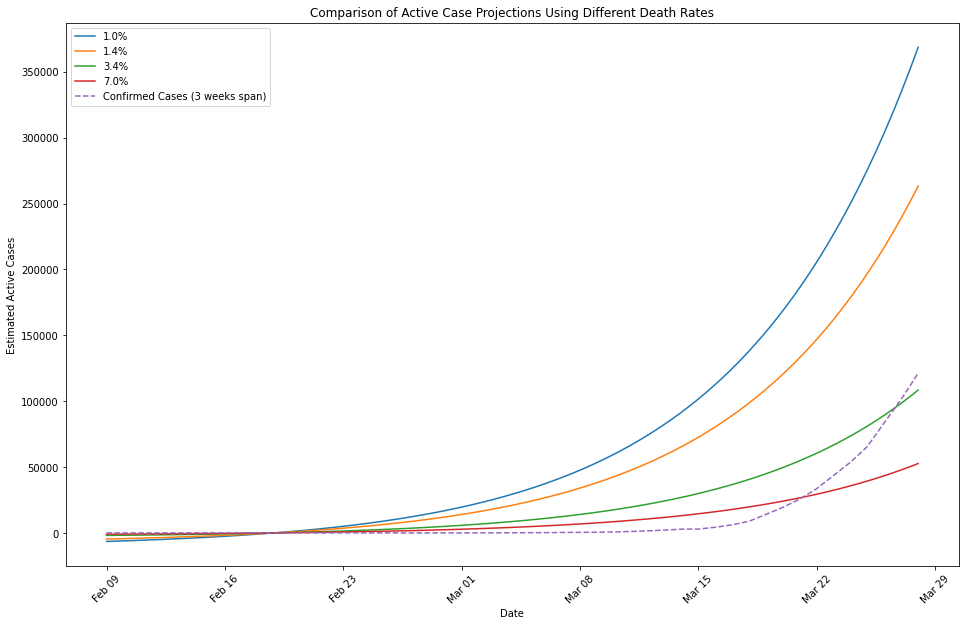

In [26]:
plt.figure(figsize = [16,10])
death_pred_comparison([0.01, 0.014, .034, .07], daily_new_deaths)

here are a few things that should be noted about this plot. The goal is to create an estimate of active cases using the information that we have and presumes uncertainty about the disease. It assumes that the count of deaths is significantly due to COVID-19 is more accurate than the number of confirmed cases (compared to actual cases). It also is modeled off of data primarily before stay-at-home orders were made. This model may be good at predicting what would have happened had the orders not been made, but the actions taken by the American people have changed the trajectory of this virus.

Finally, the regression is a exponential regression. At the start of any pandemic, exponential models fit fairly well, however they will diverge compared to the traditional SIR Model for Spread of Disease as a significant portion of the population has had the disease.

What information we can note from the above plot is some missing information related to infections early on in the pandemic as well as the wonderful news that the death rate of the virus seems lower than initially predicted. The data seems to be consistent with a death rate lower than 3.4% and is consistent with recent research estimating the death rate as between 0.39% and 1.33%. Note that this research is based on data from China and may not apply well to the United States. The death rate also may be signficantly different if we hit medical care capacity.

Slight pivot. Now that we are looking at the date of the various stay at home orders, we need a function the converts the integer to the date.

First, we take the column and replace null values with some sentinal. I let that sentinal be 0. A 0 value may be interpretted that a stay at home order occured year 1. Obviously untrue, so we may need to look at other options, such as week numbers or an encoding to determine if there was any stay at home order.

The two questions needed to be addressed: 

How might we predict severity of outbreaks by the features in the data set ( projecting it onto other counties)?

How accurate is testing and what are ways to monitor the status of infectious spread other than just cumulative confirmed cases?




Goal:
Observe the factors which have the most influence in predicting outbreaks. 

# Data Cleaning

The following functions are built to the clean data and feature engineer  

In [0]:
def float_to_date(time):
  # Takes date formated as days since the beginning of the gregorian calender and returns a date object.
  # This does not handle null values.
  if (time == 0):
    return datetime.date(year = 2020, month = 4, day = 19)
  return datetime.date(year = 1, month = 1, day = 1) + datetime.timedelta(days = time)

def feature_prep(df):
  #Feature selection, Feature Engineering, and One hot encoding 
  features = ["Rural-UrbanContinuumCode2013", "PopulationEstimate2018", "PopulationDensityperSqMile2010", "dem_to_rep_ratio", "SVIPercentile", "HPSAShortage", "public schools", ">500 gatherings", "stay at home", "thresholdPassed", "growth"]
  dates = ["public schools", ">500 gatherings", "stay at home", "thresholdPassed"]
  dummy = ["public schools before", "public schools during", ">500 gatherings before", ">500 gatherings during", "stay at home before", "stay at home during"]
  medicare_ratio = df["#EligibleforMedicare2018"] / df["PopulationEstimate2018"]
  res_df = df.copy()[features]
  res_df["MedicareRatio"] = medicare_ratio
  start_date = pd.to_datetime(datetime.date(2020, 1, 22))
  print(res_df["growth"].sort_values())
  #used log to linearize the data
  res_df["growth"] = np.log(df["growth"].astype(int))
  res_df = res_df.apply(lambda x: (x - start_date).dt.days if x.name in dates else x)
  res_df = (res_df - np.mean(res_df)) / np.std(res_df)
  res_df[dummy] = df[dummy]
  return res_df

def feature_select(df):
#drops desired columns and preps dataframe for model
  df = feature_prep(df)
  return df.drop(["PopulationDensityperSqMile2010","public schools during", ">500 gatherings during","stay at home during", ">500 gatherings before"], axis = 1)

Cleaning data for merge


In [28]:
#Cleaning up df by dropping all the na values and converting it into int val for future mapping
time_series_covid19_confirmed_US["FIPS"] = time_series_covid19_confirmed_US["FIPS"].dropna()
time_series_covid19_confirmed_US = time_series_covid19_confirmed_US.dropna(subset=["FIPS"]).astype({'FIPS' : int})
abridged_counties["countyFIPS"] = pd.to_numeric(abridged_counties["countyFIPS"], errors="coerce")
abridged_counties.dropna(subset=["countyFIPS"]).astype({'countyFIPS' : int})

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944.0,21

In [29]:
#Converting float values to YYYY-MM-DD format
pd.to_datetime(abridged_counties["stay at home"].fillna(0).apply(float_to_date).sort_values())

241    2020-03-20
209    2020-03-20
208    2020-03-20
207    2020-03-20
206    2020-03-20
          ...    
1719   2020-04-19
1718   2020-04-19
1717   2020-04-19
1715   2020-04-19
3243   2020-04-19
Name: stay at home, Length: 3244, dtype: datetime64[ns]

In [30]:
counties_with_metro = abridged_counties.merge(metropolitan_areas, on = "countyFIPS").merge(time_series_covid19_confirmed_US, left_on = "countyFIPS", right_on = "FIPS")
counties_with_metro

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,1001.0,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,6,6,6,6,6,7,8,10,12,12,12,12,12,12,15,17,19,19,19,23,24,26,26,25
1,1003.0,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,0,0,0,0,0,1,1,1,1,1,2,2,2,3,4,4,5,5,10,15,18,19,20,24,28,29,29,38,42,44,56,59,66,71,72,87,91,101,103,109
2,1005.0,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,3,3,4,9,9,10,10,11,12,14,15,18
3,1007.0,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,3,4,4,4,5,7,8,9,9,11,13,16,17,17,18,22,24,26
4,1009.0,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944.0,2113.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,5,5,5,5,5,6,9,10,10,10,10,10,11,12,12,13,14,16,17,18,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,56039.0,56.0,39.0,Teton,WY,Wyoming,43.713556,-110.570974,43.494174,-110.784353,West,Mountain,7.0,23081.0,12075.0,11190.0,0.519020,3349.0,5.3,21294.0,36.9,3765.0,3144.0,NaN,2.1,90.7,28.9,14.546369,36.09,604.0,147.0,0.0,1.0,6.0,1.865340,660.0,623.0,556.0,534.0,510.0,...,0,0,0,0,0,0,0,0,0,1,2,2,2,2,2,5,7,10,13,14,16,20,26,29,32,36,39,40,41,44,45,50,53,56,56,57,58,59,61,62
1837,56041.0,56.0,41.0,Uinta,WY,Wyoming,41.289323,-110.553036,41.271860,-110.767519,West,Mountain,7.0,20299.0,10335.0,10160.0,0.504269,2703.0,10.2,21118.0,33.9,3594.0,2591.0,NaN,10.5,184.6,32.0,17.212675,81.51,478.0,26.0,0.0,1.0,6.0,0.195320,915.0,866.0,906.0,882.0,895.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,3,3,3,3,4,4,4,4,4,4,4,6,6
1838,56045.0,56.0,45.0,



```
# This is formatted as code
```

Filled the columns '1/22/20' - '4/18/20' of the time series with 0 if they went to 0 randomly. The data entries presumeably are incorrect.
Example: 


In [31]:
counties_with_metro[counties_with_metro["CBSA Code"] == 30860]

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
359,16041.0,16.0,41.0,Franklin,ID,Idaho,42.180047,-111.819726,42.099300,-111.872202,West,Mountain,3.0,13726.0,6925.0,6639.0,0.510543,1884.0,19.3,12786.0,31.5,2354.0,1909.0,NaN,6.8,136.4,40.9,13.216662,35.75,300.0,6.0,0.0,1.0,0.0,0.098693,641.0,578.0,696.0,596.0,667.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1618,49005.0,49.0,5.0,Cache,UT,Utah,41.726883,-111.753142,41.744338,-111.840612,West,Mountain,3.0,127068.0,62411.0,62027.0,0.501543,11447.0,96.7,112656.0,25.5,14213.0,11540.0,21.0,6.8,124.8,37.0,8.610785,30.45,1005.0,221.0,0.0,2.0,14.0,0.405081,5773.0,5745.0,5199.0,5013.0,4501.0,...,0,0,0,0,0,0,0,0,0,2,2,2,2,3,3,0,0,0,5,5,0,7,7,7,15,16,19,22,24,28,29,30,34,33,36,36,37,37,0,0


In [0]:
for index, row in counties_with_metro.iterrows():
  counties_with_metro.loc[index,"1/22/20":] = row.loc["1/22/20":].replace(to_replace=0, method='ffill')

The following are methods to standardize numeric values 

The method to calculate the weighted mean:[solution by jrjc on StackOverflow](https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe).

In [0]:
weighted_mean = lambda x: np.average(x, weights=counties_with_metro.loc[x.index, "PopulationEstimate2018"])
first = lambda x: x.iloc[0]

In [0]:
metro_agg = {
    "CBSA Title" : first,
    "POP_LATITUDE"  : weighted_mean,
    "POP_LONGITUDE" : weighted_mean,
    "State"         : first, # NOT REFLECTIVE OF ALL COUNTIES
    "StateName"     : first, # NOT REFLECTIVE OF ALL COUNTIES
    "CountyName" : first, # NOT REFLECTIVE OF ALL COUNTIES
    "Rural-UrbanContinuumCode2013" : weighted_mean,
    "PopulationEstimate2018"  : sum,
    "PopulationDensityperSqMile2010" : weighted_mean, # This is likely bilinear with population
    "dem_to_rep_ratio" : weighted_mean,
    "#EligibleforMedicare2018" : sum,
    "SVIPercentile" : weighted_mean,
    "HPSAShortage" : sum,
    "public schools" : weighted_mean,
    ">500 gatherings" : weighted_mean,
    "stay at home" : weighted_mean
}

# This sets all the time series columns to be the sum of all counties
metro_agg.update(dict.fromkeys(counties_with_metro.loc[0,"1/22/20":].index, 'sum'))
metro_stats = counties_with_metro.sort_values("PopulationEstimate2018", ascending = False).groupby("CBSA Code").agg(metro_agg)
 
for column in ["stay at home", "public schools", ">500 gatherings"]:
  metro_stats[column] = pd.to_datetime(metro_stats[column].fillna(777777).apply(float_to_date))

#Features Engineering and OHE

The following:
- retrieves the dates when threshold hits n cases and the date x days later

- calculates growth of confirmed cases within the x days 

- One hot encodes if threshold hit before or after public schools closed, >500 gatherings banned, and stay at home was inplace. 

In [35]:
dates = np.array(counties_with_metro.loc[0,"1/22/20":].index)
dates

array(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20',
       '2/9/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20',
       '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20',
       '2/27/20', '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20',
       '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20',
       '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20', '3/15/20',
       '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20', '3/21/20',
       '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20', '3/27/20',
       '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20', '4/2/20',
       '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20', '4/11/20', '4/12/20', '4/13/20', '4/14/20',
     

In [36]:
metro_stats_copy = pd.DataFrame(columns = [col for col in metro_stats.columns if col not in dates] + ["thresholdPassed", "thresholdEnd", "growth"])#, "schoolBefore", "schoolDuring", "schoolAfter", "gatheringsBefore", "gatheringsDuring", "gatheringsAfter", "homeBefore", "homeDuring", "homeAfter"])
THRESHOLD = 50
DAYS = 10
for index, row in metro_stats.iterrows():
  row_dates = (row[dates])[row[dates] > THRESHOLD]
  if len(row_dates) > DAYS:
    first_date = pd.to_datetime(row_dates.index[0])
    last_date = first_date + datetime.timedelta(DAYS)
    growth_over_days = row_dates[DAYS] - row_dates[0]
    new_row = dict(row[:"stay at home"])
    new_row.update(
        {"thresholdPassed" : first_date, "thresholdEnd" : last_date, "growth" : growth_over_days}
        )
    metro_stats_copy.loc[index] = new_row

for category in ["public schools", ">500 gatherings", "stay at home"]:
  metro_stats_copy[category + " before"] = (metro_stats_copy[category] < metro_stats_copy["thresholdPassed"]).astype(int)
  metro_stats_copy[category + " during"] = ((metro_stats_copy["thresholdPassed"] < metro_stats_copy[category]) & (metro_stats_copy[category] < metro_stats_copy["thresholdEnd"])).astype(int)

metro_stats_copy

,CBSA Title,POP_LATITUDE,POP_LONGITUDE,State,StateName,CountyName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopulationDensityperSqMile2010,dem_to_rep_ratio,#EligibleforMedicare2018,SVIPercentile,HPSAShortage,public schools,>500 gatherings,stay at home,thresholdPassed,thresholdEnd,growth,public schools before,public schools during,>500 gatherings before,>500 gatherings during,stay at home before,stay at home during
10420,"Akron, OH",41.128332,-81.457551,Ohio,OH,Summit,2.0,704845.0,1085.746496,1.108766,147972.0,0.313082,0.000,2020-03-18,2020-03-16,2020-03-24,2020-03-26,2020-04-05,210,1,0,1,0,1,0
10500,"Albany, GA",31.601130,-84.142283,Georgia,GA,Dougherty,3.0,149917.0,197.626666,1.559653,30148.0,0.803432,9.775,2020-03-19,2020-03-18,2020-03-27,2020-03-20,2020-03-30,273,1,0,1,0,0,1
10580,"Albany-Schenectady-Troy, NY",42.790363,-73.818228,New York,NY,Albany,2.0,883169.0,452.068424,1.244445,187090.0,0.263539,2.760,2020-03-19,2020-03-14,2020-03-23,2020-03-18,2020-03-28,351,0,1,1,0,0,1
10740,"Albuquerque, NM",35.109071,-106.621428,New Mexico,NM,Bernalillo,2.0,915927.0,434.665996,1.368409,183604.0,0.670540,16.540,2020-03-17,2020-03-19,2020-03-25,2020-03-25,2020-04-04,220,1,0,1,0,0,0
10780,"Alexandria, LA",31.321241,-92.470010,Louisiana,LA,Rapides,3.0,153044.0,90.322190,0.447977,33489.0,0.867292,10.580,2020-03-17,2020-03-18,2020-03-24,2020-03-31,2020-04-10,107,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49180,"Winston-Salem, NC",36.052220,-80.283905,North Carolina,NC,Forsyth,2.0,671456.0,581.728957,0.837400,142615.0,0.640241,7.730,2020-03-17,2020-03-13,2020-03-31,2020-03-28,2020-04-07,159,1,0,1,0,0,1
49340,"Worcester, MA-CT",42.242036,-71.828748,Massachusetts,MA,Worcester,2.0,947866.0,491.844870,1.209483,184499.0,0.411279,0.000,2020-03-18,2020-03-18,2020-03-24,2020-03-24,2020-04-03,777,1,0,1,0,0,0
49420,"Yakima, WA",46.515822,-120.416190,Washington,WA,Yakima,3.0,251446.0,56.600000,0.749754,43588.0,0.927700,40.410,2020-03-18,2020-03-12,2020-03-24,2020-03-26,2020-04-05,265,1,0,1,0,1,0
49620,"York-Hanover, PA",39.942113,-76.750832,Pennsylvania,PA,York,2.0,448273.0,481.100000,0.533145,94910.0,0.329000,0.000,2020-03-17,2020-03-24,2020-03-28,2020-03-30,2020-04-09,196,1,0,1,0,1,0


Checking if all values are mean cetnered and within 1 standard deviation 


In [37]:
mean_centered_metro = feature_prep(metro_stats_copy)
print(f"Means:\n{np.round(np.mean(mean_centered_metro),5)}\n\nStd:\n{np.round(np.std(mean_centered_metro),5)}")
mean_centered_metro

39150      12
21300      17
44300      18
14720      20
48900      20
         ... 
37980    1330
26900    1331
16980    1452
35620    1609
19820    3835
Name: growth, Length: 300, dtype: object
Means:
Rural-UrbanContinuumCode2013      0.00000
PopulationEstimate2018           -0.00000
PopulationDensityperSqMile2010   -0.00000
dem_to_rep_ratio                 -0.00000
SVIPercentile                     0.00000
HPSAShortage                     -0.00000
public schools                   -0.00000
>500 gatherings                  -0.00000
stay at home                      0.00000
thresholdPassed                  -0.00000
growth                            0.00000
MedicareRatio                     0.00000
public schools before             0.89333
public schools during             0.09000
>500 gatherings before            0.84667
>500 gatherings during            0.10667
stay at home before               0.47667
stay at home during               0.31000
dtype: float64

Std:
Rural-UrbanContinuumC

,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopulationDensityperSqMile2010,dem_to_rep_ratio,SVIPercentile,HPSAShortage,public schools,>500 gatherings,stay at home,thresholdPassed,growth,MedicareRatio,public schools before,public schools during,>500 gatherings before,>500 gatherings during,stay at home before,stay at home during
10420,-0.414926,-0.100668,0.450223,-0.010606,-0.977883,-0.646870,-0.314709,-0.101308,-0.274735,-0.439595,0.409642,0.117020,1,0,1,0,1,0
10500,0.389637,-0.405916,-0.310095,0.566965,1.186098,-0.015176,0.042915,-0.100809,-0.274443,-1.320742,0.665454,-0.056213,1,0,1,0,0,1
10580,-0.414926,-0.002578,-0.092268,0.163195,-1.196522,-0.468509,0.042915,-0.101807,-0.274832,-1.614458,0.910492,0.154340,0,1,1,0,0,1
10740,-0.414926,0.015441,-0.107166,0.321987,0.599629,0.422000,-0.672332,-0.100559,-0.274638,-0.586452,0.455000,-0.068777,1,0,1,0,0,0
10780,0.389637,-0.404196,-0.401958,-0.857055,1.467921,0.036845,-0.672332,-0.100809,-0.274735,0.294695,-0.247798,0.291162,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49180,-0.414926,-0.119034,0.018734,-0.358217,0.465915,-0.147331,-0.672332,-0.102056,-0.274054,-0.145879,0.138386,0.165263,1,0,1,0,0,1
49340,-0.414926,0.033010,-0.058215,0.118409,-0.544525,-0.646870,-0.314709,-0.100809,-0.274735,-0.733310,1.685301,-0.182670,1,0,1,0,0,0
49420,0.389637,-0.350068,-0.430827,-0.470488,1.734509,1.964559,-0.314709,-0.102306,-0.274735,-0.439595,0.636455,-0.600140,1,0,1,0,1,0
49620,-0.414926,-0.241800,-0.067414,-0.747957,-0.907633,-0.646870,-0.672332,-0.099311,-0.274346,0.147837,0.342372,0.152071,1,0,1,0,1,0


# More Data Feature selection 

Checking for colinear features 

In [0]:
# This takes forever to run. Only run if you want to see the pairplot
#g = sns.pairplot(mean_centered_metro)

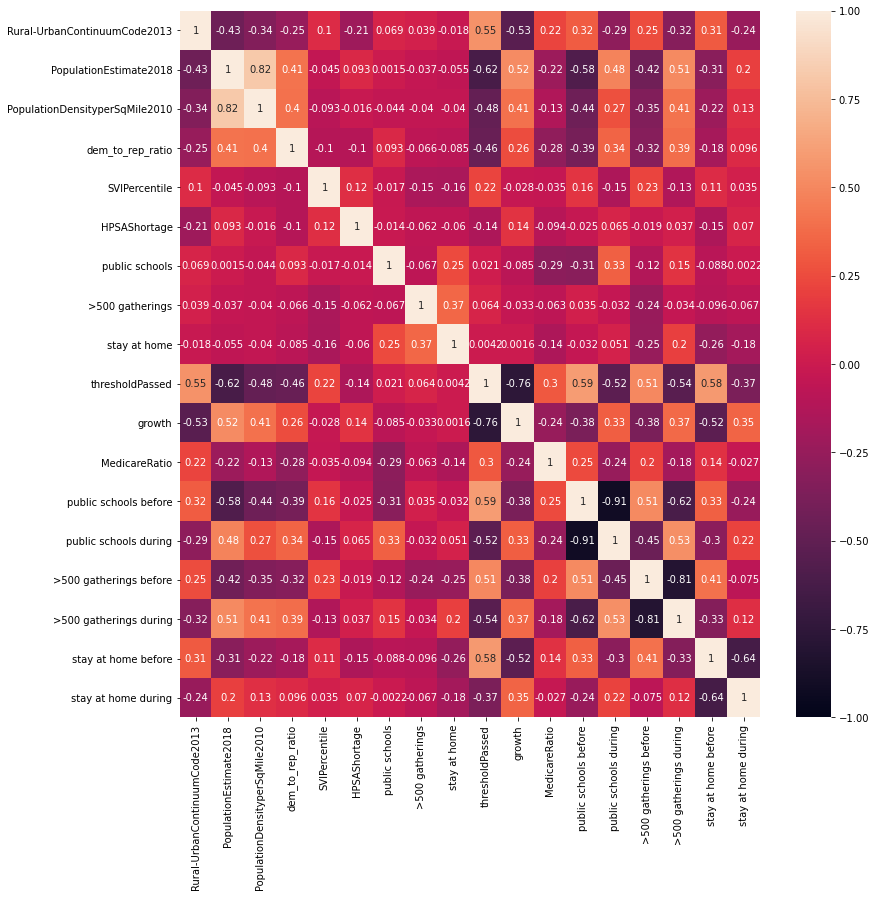

In [39]:
plt.figure(figsize=(13,13))
sns.heatmap((mean_centered_metro.astype(float)).corr(), annot=True, vmin=-1, vmax=1);

We can see above that there are 
strong correlations between the categorical variables (as they are related to each other). It seems best to drop them to reduce multicolinearity.

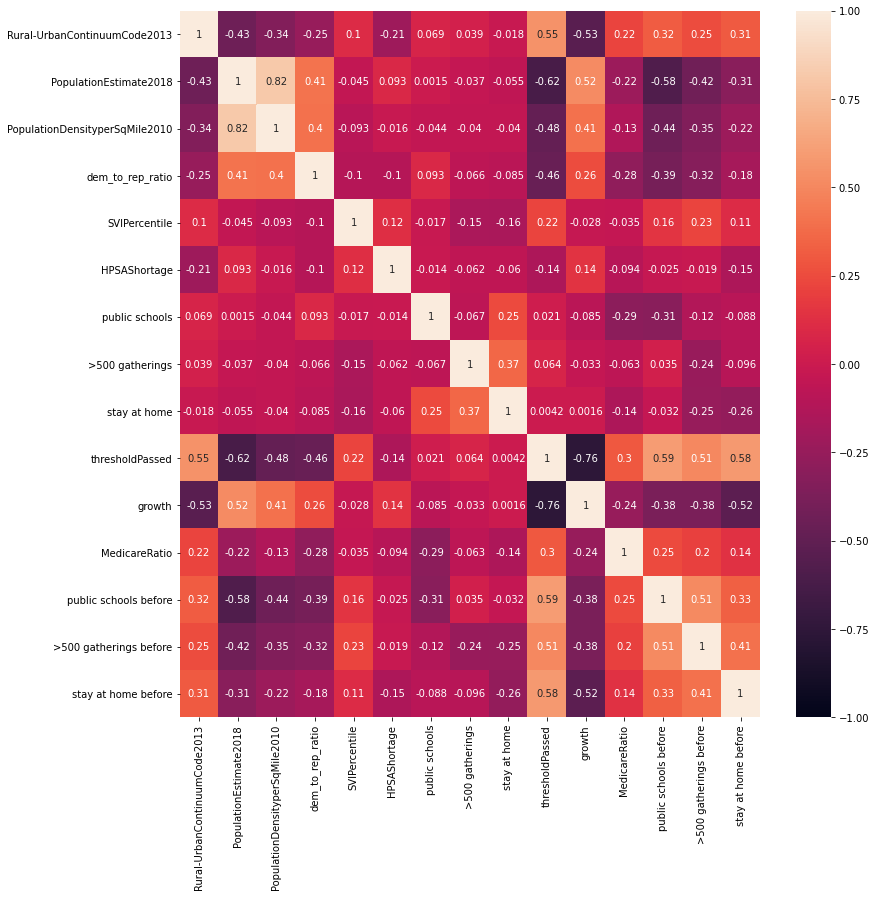

In [40]:
plt.figure(figsize=(13,13))
sns.heatmap((mean_centered_metro.astype(float).drop(["public schools during", ">500 gatherings during","stay at home during"], axis = 1)).corr(), annot=True, vmin=-1, vmax=1);

This is already looking much better, however there does seem to be that a strong relationship between population and population density (as to be expected). The two rows have almost identical color distributions, so we can pick one to remove as not much is added.

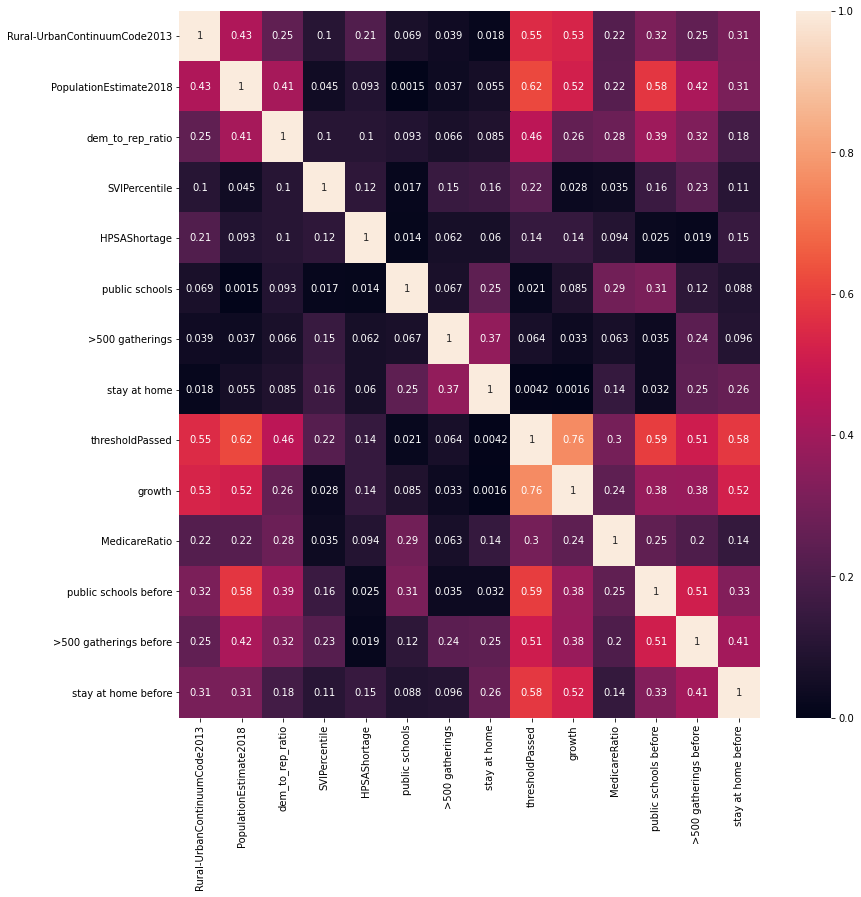

In [41]:
plt.figure(figsize=(13,13))
sns.heatmap(np.abs((mean_centered_metro.astype(float).drop(["PopulationDensityperSqMile2010","public schools during", ">500 gatherings during","stay at home during"], axis = 1)).corr()), annot=True, vmin=0, vmax=1);

As we can see, this graph shows much less correlation between variables. When determining strength of correlation, the magnitude of the correlation is what is most important, so the sign does not matter. For visibility, lets see what the heatmap look like when taking the absolute value of correlation.

In [42]:
mean_centered_metro_selected = feature_select(metro_stats_copy)

39150      12
21300      17
44300      18
14720      20
48900      20
         ... 
37980    1330
26900    1331
16980    1452
35620    1609
19820    3835
Name: growth, Length: 300, dtype: object


We know have our dataframe clean and ready to use in creating a  model 

In [43]:
mean_centered_metro_selected.head()

,Rural-UrbanContinuumCode2013,PopulationEstimate2018,dem_to_rep_ratio,SVIPercentile,HPSAShortage,public schools,>500 gatherings,stay at home,thresholdPassed,growth,MedicareRatio,public schools before,stay at home before
10420,-0.414926,-0.100668,-0.010606,-0.977883,-0.646870,-0.314709,-0.101308,-0.274735,-0.439595,0.409642,0.117020,1,1
10500,0.389637,-0.405916,0.566965,1.186098,-0.015176,0.042915,-0.100809,-0.274443,-1.320742,0.665454,-0.056213,1,0
10580,-0.414926,-0.002578,0.163195,-1.196522,-0.468509,0.042915,-0.101807,-0.274832,-1.614458,0.910492,0.154340,0,0
10740,-0.414926,0.015441,0.321987,0.599629,0.422000,-0.672332,-0.100559,-0.274638,-0.586452,0.455000,-0.068777,1,0
10780,0.389637,-0.404196,-0.857055,1.467921,0.036845,-0.672332,-0.100809,-0.274735,0.294695,-0.247798,0.291162,1,1


In [56]:
mean_centered_metro_selected.shape

(300, 13)

In [60]:
counties_with_metro.shape

(1841, 198)

# Modeling

Functions used in modeling.

In [0]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))


def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

#Code for VIF Calculation 
#The following code was taken from:
#https://statinfer.com/204-1-9-issue-of-multicollinearity-in-python/ 
#Writing a function to calculate the VIF values
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

In [45]:
X = mean_centered_metro_selected.drop(['growth'], axis = 1)
y = mean_centered_metro_selected.loc[:, 'growth']
#Splitting the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train = X_train.fillna(0)
#Using LinearRegression to fit our model 
model = LinearRegression().fit(X_train, y_train)
model.score(X_train, y_train)

0.654629406475128

In [46]:
cross_validate_rmse(model, X_train, y_train)

0.6232732691739818

Test CV Score 

In [47]:
model.score(X_test, y_test)

0.442453116298849

Variance Inflation Factor 

In [48]:
import statsmodels.formula.api as sm
vif_cal(mean_centered_metro_selected.copy(), "growth")

Rural-UrbanContinuumCode2013  VIF =  1.53
PopulationEstimate2018  VIF =  1.98
dem_to_rep_ratio  VIF =  1.45
SVIPercentile  VIF =  1.19
HPSAShortage  VIF =  1.14
public schools  VIF =  1.5
>500 gatherings  VIF =  1.25
stay at home  VIF =  1.43
thresholdPassed  VIF =  3.61
MedicareRatio  VIF =  1.35
public schools before  VIF =  2.17
stay at home before  VIF =  1.8


#Graphing and EDA of final model 

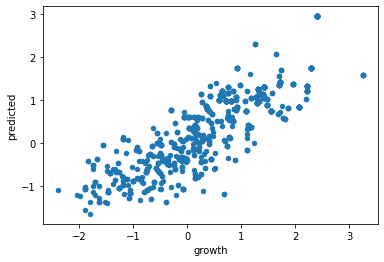

In [49]:
metro_joined = mean_centered_metro_selected.copy()
metro_joined["predicted"] = model.predict(mean_centered_metro_selected.drop(['growth'], axis = 1).fillna(0))
metro_joined = metro_joined.reset_index().rename(columns={"index":"CBSA Code"}).merge(counties_with_metro[["CBSA Code", "countyFIPS","CountyName"]], on = "CBSA Code")
metro_joined.plot(x="growth", y = "predicted", kind = "scatter")

Text(0, 0.5, 'Predicted Growth')

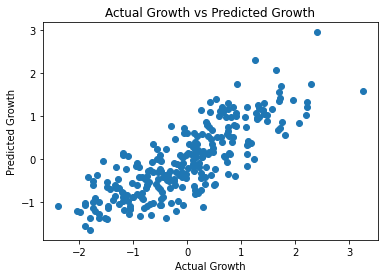

In [50]:
#plt.scatter(x=y_train, y=model.predict(X_train))
result = X_train.copy()
result["growth"] = y_train
result["predicted"] = model.predict(X_train)
plt.scatter(y_train, model.predict(X_train))
plt.title("Actual Growth vs Predicted Growth")
plt.xlabel("Actual Growth")
plt.ylabel("Predicted Growth")

In [51]:

model.coef_

array([-0.15032766,  0.10342846, -0.12371145,  0.14650524, -0.03667081,
       -0.0099293 ,  0.02581195, -0.02424999, -0.71197636, -0.02481944,
        0.41657657, -0.23658888])

Maps of Growth and predicted growth

In [52]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = metro_joined.copy()
df["countyFIPS"] = df["countyFIPS"].astype(int).astype(str).str.zfill(5)
import plotly.express as px

fig = px.choropleth_mapbox(df, geojson=counties, locations= df.countyFIPS, color=df.growth,
                           color_continuous_scale="Viridis",
                           range_color=(-3, 4),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [53]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = metro_joined.copy()

import plotly.graph_objects as go
df["countyFIPS"] = df["countyFIPS"].astype(int).astype(str).str.zfill(5)

fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=df.countyFIPS, z=df.predicted,
                                    colorscale="Viridis", zmin=-3, zmax=4,
                                    marker_opacity=0.5, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3, mapbox_center = {"lat": 37.0902, "lon": -95.7129})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [54]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd
df = metro_joined.copy()

import plotly.graph_objects as go
df["countyFIPS"] = df["countyFIPS"].astype(int).astype(str).str.zfill(5)

fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=df.countyFIPS, z=df.predicted - df.growth,
                                    colorscale="Viridis", zmin=-3, zmax=4,
                                    marker_opacity=0.5, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3, mapbox_center = {"lat": 37.0902, "lon": -95.7129})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output hidden; open in https://colab.research.google.com to view.

From the graphs above, we can see that there is no discernible geographic pattern to over or underestimation. While this does not eliminate patterns in estimation, it does suggest that not including regional features did not have a huge effect on the model. So, in the end, we have these features and these coefficients

# FIXME: COEFFICENTS ANALYSIS OF THE MODEL

In [55]:
pd.DataFrame().from_dict(dict(zip(X.columns, model.coef_)), orient = 'index').sort_values(0)

,0
thresholdPassed,-0.711976
stay at home before,-0.236589
Rural-UrbanContinuumCode2013,-0.150328
dem_to_rep_ratio,-0.123711
HPSAShortage,-0.036671
MedicareRatio,-0.024819
stay at home,-0.024250
public schools,-0.009929
>500 gatherings,0.025812
PopulationEstimate2018,0.103428
